# Understanding the spread of COVID-19 based on Google's traffic data in European countries during autumn

## Structure

## Introduction


### Problem

COVID-19 pandemic caused massive lockdowns during spring 2020. However lockdowns have massive side effects, f.e. mental health problems and unemployment. It is clear that governments would like to implement smart lockdowns which was reduce only that kind of traffic which causes the spread of COVID-19 but no more.


### Motivation

This data science project tries to answer how smart lockdowns should be implemented.


### The main modeling idea

Let's use commonly known commonly known extended SIR-models and create a Bayesian model which uses Google's traffic data and the information of COVID-19 deaths.  Based on the created model, trying to understand which of these Google's traffic components predicted the spread of COVID-19 in our prototype country: Spain. However, this notebook is built in a way that extending the analysis on multiple countries is possible.

### Data

- Data on deaths in different countries, Our World in Data COVID-19 dataset


- Google's traffic data 
    - Google provides anonymized insights from products such as Google Maps for researchers to help them to make critical analysis to combat COVID-19. 
    - Google has divided their traffic data into six traffic components: 
        1. retail \& recreation
            - places like restaurants, cafes, shopping centers, theme parks, museums, libraries and movie theaters
        2. grocery \& pharmacy
            - places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores and pharmacies
        3. parks
            - places like national parks, public beaches, marinas, dog parks, plazas and public gardens
        4. transit stations
            - places like public transport hubs such as subway, bus and train stations
        5. workplaces 
            - places of work
        6. residential 
            -  places of residence
     
  - These components do not tell anything how much time people spend in each section on average but they still give a lot of information how people's traffic behavior changed during the pandemic
 
 - The traffic data's baseline is counted as a median value of multiple days. Day-to-day changes should not be emphasized too much because they are effected on many different factors, f.e. the weather and public events.  

- Later on nice visualisations about the data!


### Why this data?


- Getting the traffic data down slows down the spread of the virus. 
    - Several articles (Ferretti et al 2020, ECDC report, LSHTM report) have pointed out pre-symptomatic and asymptomatic  infections  play  a  significant  role  in  the  spread  of  COVID-19.  Indeed,  this observation  is  an  argument  it  may  not  be  enough  to  get  the  symptomatic  cases  to  stay at  home. Also  governmental  restrictions  should  be  implemented  to  get people’s movement down and furthermore the pandemic under control.
    - Essentially, the reason to implement non-pharmaceutical interventions is to get people's traffic data down!

    
- The COVID-19-case data is not reliable at least as the only measure about the development of the epidemic. COVID-19-death data has many benefits compared to the COVID-19 case data! 
    - The amount of testing varies a lot between countries
    - Also using death data over infected data has the benefit that deaths measures much better country's success against the epidemic than infections
    

### Libraries used in this notebook

In [1]:
%load_ext stanmagic

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pystan
import arviz as az
import stan_utils

### Parameters which need to be defined manually

- All the parameters, which need to be defined manually, are here


- During text there are detailed explanations what these parameters are

In [2]:
#############################################################################

# There is COVID-19-data from February until now
observations_start_date = datetime.datetime(2020, 2, 1, 0, 0)
observations_end_date = datetime.datetime(2020, 11, 28, 0, 0)

# However, the data analysis of this notebook concentrates on autumn months, i.e. on so called tail
tail_start_date = datetime.datetime(2020, 8, 1, 0, 0)


#############################################################################

# We use Spain as our example country
example_countries = ['Spain']


#############################################################################

# Window size for convolution
w = 7

# Death limit to remove noise
d = 5

# Analysed weeks
weeks_analysed = 17


#############################################################################
# LFO
M = 3
L = 12

In [3]:
# Follows directly from manual definitions 
# num_countries = len(european_countries)
whole_interval_len = (observations_end_date - observations_start_date).days 
tail_interval_len = (observations_end_date - tail_start_date).days 
date_list = [observations_start_date + datetime.timedelta(days=x) for x in range(whole_interval_len)]

# print("There are " + str(num_countries) + " European countries analysed in this notebook.")
# print("The length of the whole interval: " + str(whole_interval_len))
# print("The length of the tail interval: " + str(tail_interval_len))

### Adding previously cleaned data to dataframes 

- Details from the data cleaning are not in this notebook which hopefully makes this notebook easier to follow. 

In [4]:
# A dataframe sorted by countries

dtypes_countries = np.dtype([
          ('country', str),
          ('population', int),
          ('population_in_millions', int),
          ])

df_countries = pd.DataFrame(pd.read_csv('Cleaned_dataframes/df_countries.csv', dtype=dtypes_countries))

# Show the dataframe
df_countries

,country,population,population_in_millions
0,Germany,83783945,84
1,United Kingdom,67886004,68
2,France,65273512,65
3,Italy,60461828,60
4,Spain,46754783,47
5,Ukraine,43733759,44
6,Poland,37846605,38
7,Romania,19237682,19
8,Netherlands,17134873,17
9,Belgium,11589616,12


In [5]:
# A countrywise sorted dataframe s.t. for each day on the time interval of each country there is a row 

dtypes_days_by_countries = np.dtype([
          ('country', str),  # country name
          ('date', str), # current date. This will become datetime-time using parse_dates!
          ('new_deaths', int), # new deaths on that date
          ('new_deaths_smooth', int), # smoothened new deaths on that date
          ('total_deaths', float), # how many deaths has occured until that date
          ('traffic_retail', float), # retail and recreation traffic on that date
          ('traffic_supermarket', float), # supermarket and pharmacy traffic on that date
          ('traffic_parks', float),  # park traffic on that date
          ('traffic_transit_stations', float), # transit station traffic on that date
          ('traffic_workplaces', float), # workplace traffic on that date
          ('traffic_residential', float), # residential traffic on that date
          ('traffic_retail_smooth', float),  # park traffic on that date
          ('traffic_supermarket_smooth', float), # transit station traffic on that date
          ('traffic_parks_smooth', float),  # park traffic on that date
          ('traffic_transit_stations_smooth', float), # workplace traffic on that date
          ('traffic_workplaces_smooth', float), # residential traffic on that date
          ('traffic_residential_smooth', float),  # park traffic on that date
          ])

df_days_by_countries = pd.DataFrame(pd.read_csv('Cleaned_dataframes/df_days_by_countries.csv', dtype=dtypes_days_by_countries))   

# Change the date-column from string-type to datetype
df_days_by_countries['date'] = pd.to_datetime(df_days_by_countries['date'], format='%Y-%m-%d')


#pd.set_option('display.max_rows', None)
# Show the dataframe
df_days_by_countries

,country,date,new_deaths,new_deaths_smooth,total_deaths,traffic_retail,traffic_supermarket,traffic_parks,traffic_transit_stations,traffic_workplaces,traffic_residential,traffic_retail_smooth,traffic_supermarket_smooth,traffic_parks_smooth,traffic_transit_stations_smooth,traffic_workplaces_smooth,traffic_residential_smooth
0,Germany,2020-02-01,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,Germany,2020-02-02,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Germany,2020-02-03,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,Germany,2020-02-04,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Germany,2020-02-05,0,0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8637,Estonia,2020-11-20,1,1,87.0,-0.15,0.00,-0.18,-0.27,-0.17,0.07,-0.12,0.01,-0.08,-0.23,-0.14,0.05
8638,Estonia,2020-11-21,0,1,87.0,-0.19,0.00,-0.14,-0.28,-0.09,0.04,-0.13,0.00,-0.10,-0.24,-0.14,0.05
8639,Estonia,2020-11-22,1,1,88.0,-0.16,-0.01,0.08,-0.27,-0.11,0.02,-0.14,-0.00,-0.11,-0.25,-0.14,0.05
8640,Estonia,2020-11-23,4,1,92.0,-0.13,-0.03,-0.04,-0.24,-0.16,0.07,-0.14,-0.01,-0.10,-0.25,-0.14,0.06


### Let's visualize the data and see how COVID-19 -deaths and people's traffic behavior developed during the pandemic

We all traffic components and death data for Spain.
In this project, we concentrate our analysis what happens since 1.8.2020. The vertical black line corresponds this date.

Spain
traffic in retail and recreation


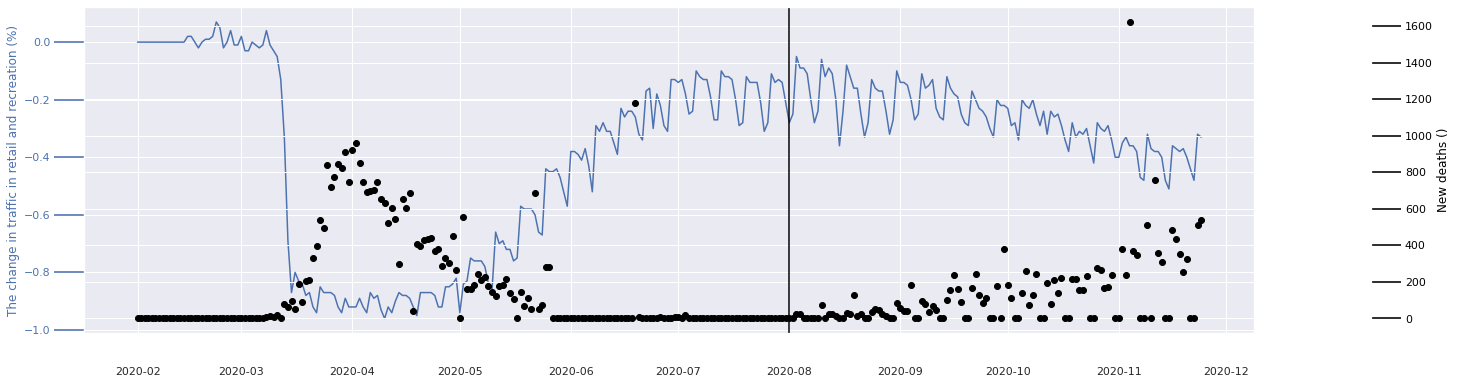

traffic in supermarkets and pharmacy


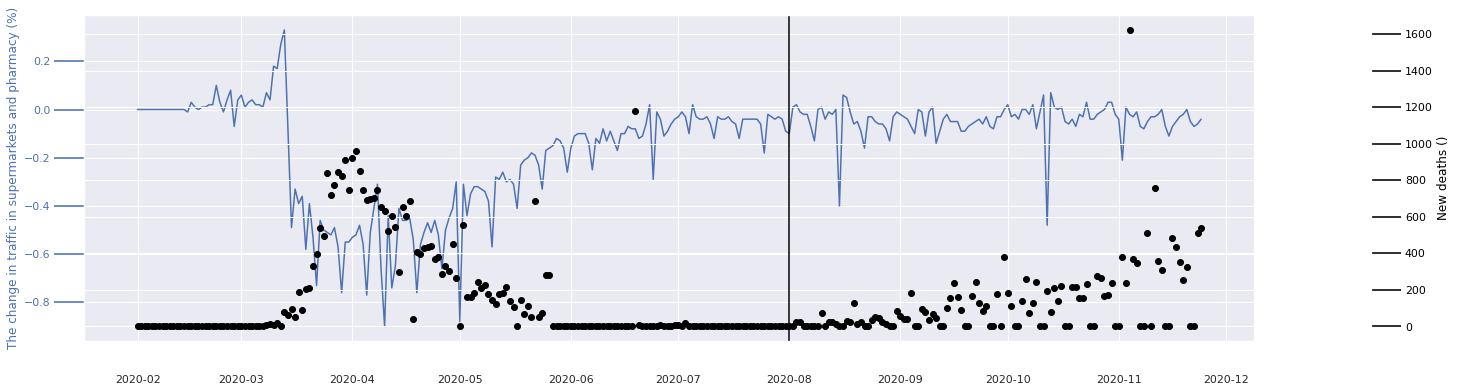

traffic in parks


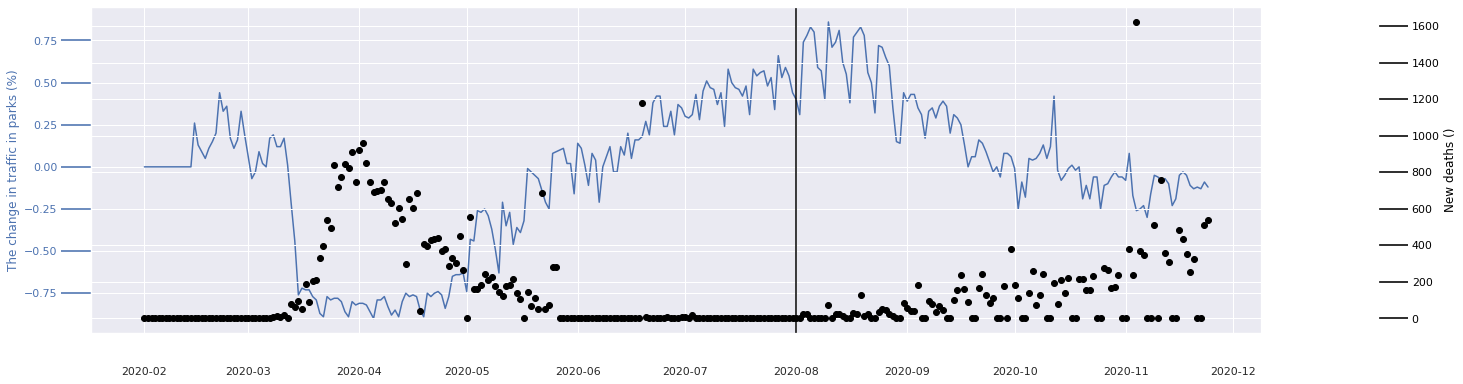

traffic in transit stations


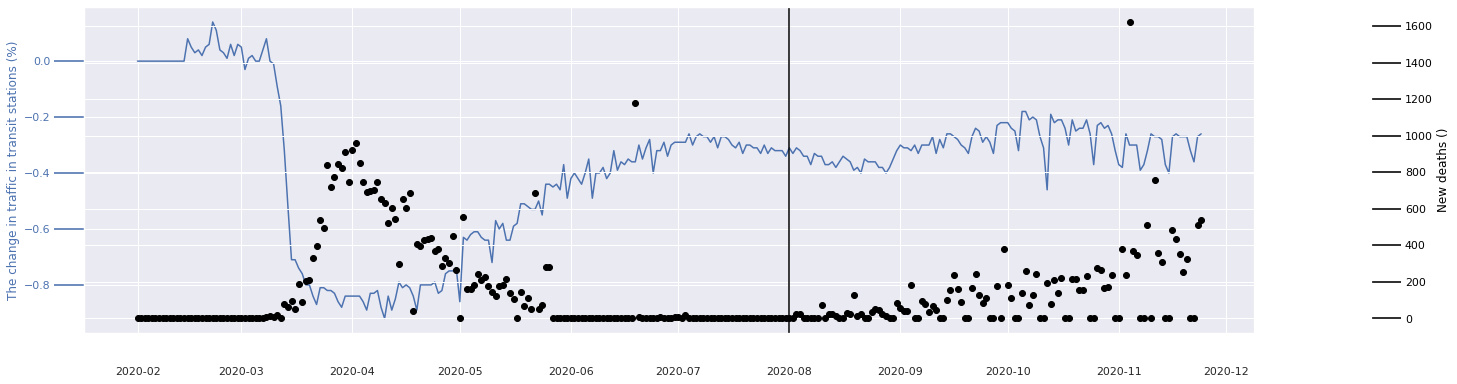

traffic in workplaces


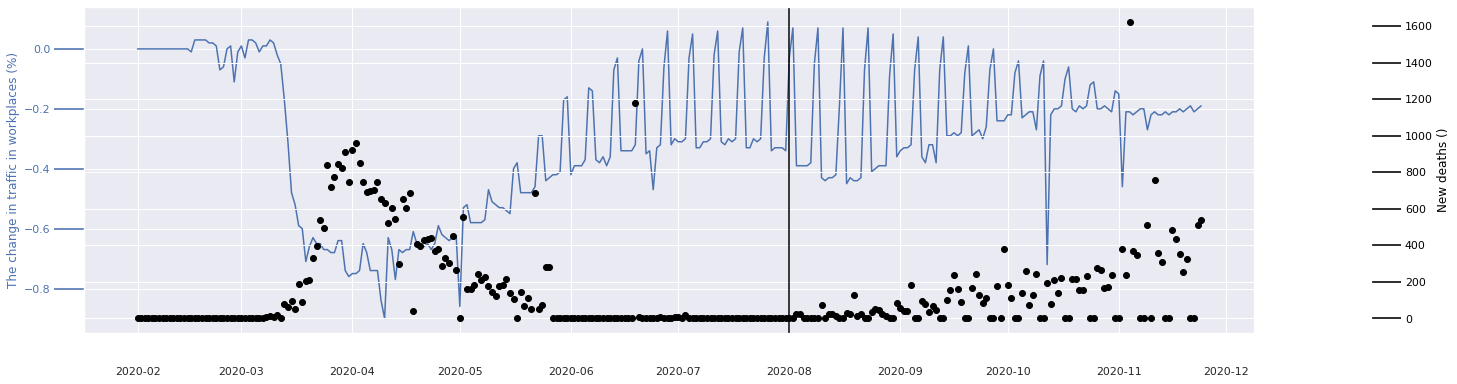

traffic in residential ares


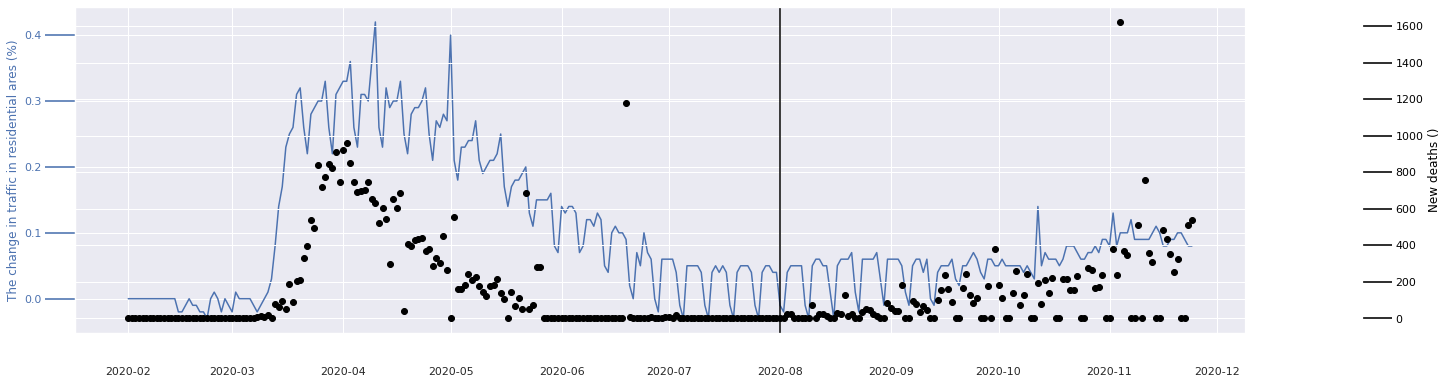

In [6]:
# Define categories which are plotted
traffic_components = ['traffic_retail', 'traffic_supermarket', 'traffic_parks', 
                      'traffic_transit_stations', 'traffic_workplaces', 'traffic_residential']

description = ['traffic in retail and recreation', 'traffic in supermarkets and pharmacy', 'traffic in parks',
               'traffic in transit stations', 'traffic in workplaces', 'traffic in residential ares']


# for i in range(num_countries): # Loop over each country
for current_country in example_countries: 

    # Define the current country, a temporary dataframe of the country and x-axis (dates)
    df_current = df_days_by_countries[(df_days_by_countries['country'] == current_country)]
    x = df_current['date'].tolist() 
    
    print('\033[1m' + current_country)
    
    # Loop over each traffic component
    for j in range(len(traffic_components)):

        # Define y-components which are going to be plotted in one figure
        y_traffic = df_current[traffic_components[j]].tolist()
        y_deaths = df_current['new_deaths'].tolist()

        # Define the figure and different y-axis (there are 3 in total: traffic, infected, deaths)
        fig, host = plt.subplots(figsize=(26, 6))
        fig.subplots_adjust(right=0.75)
        par1 = host.twinx()

        # Set the most right one y-axis to right
        par1.spines["right"].set_position(("axes", 1.1))

        # Plot the traffic, infected and death data
        p1, = host.plot(x, y_traffic, "b-", label='The change in ' + description[j] +  ' (%)' )
        p2, = par1.plot(x, y_deaths, marker = 'o', linestyle='', color = "black", label="New deaths ()")

        # Define the texts
        host.set_ylabel('The change in ' + description[j] +  ' (%)')
        par1.set_ylabel("New deaths ()")

        # Text on the axis with the correct color
        host.yaxis.label.set_color(p1.get_color())
        par1.yaxis.label.set_color(p2.get_color())

        # Make little spikes for different y-axis
        tkw = dict(size=30, width=1.6)
        host.tick_params(axis='y', colors=p1.get_color(), **tkw)
        par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
        host.tick_params(axis='x', **tkw)

        plt.axvline(tail_start_date, color='black')
        
        print('\033[0m' + description[j])
        plt.show()

### Conclusions after a first glance on the data

- It is difficult to analyse the impact of different traffic components to the spread of COVID-19 based on the first local maximum of the epidemic 
    
    - In general, traffic data components except residential traffic went strongly down at the same time. Therefore, it is difficult to say which traffic component truely mattered based on the beginning of the pandemic.
    
    
- Therefore, let's concentrate the analysis what happend later during the second wave, i.e. concentrate on the tail of the pandemic which is defined to start on 1.8.2020!

## Description of the Bayesian model

### Modified data in the model


#### Time interval

We will use time interval $T = \{1,2,3, \dots, 119 \}$ where $1$ corresponds the date 1.8.2020, $2$ corresponds the date 2.8.2020 and $119$ corresponds the date 28.11.2020. Indeed this time interval is exactly 17 weeks.


#### Deaths


Then let's define smoothened death data with $\bar{D}_{t,c} = \frac{1}{w} \sum_{t' = \text{max}(0, t - w + 1)}^{t} N_{t',c}^{(D)}$ where $w= 7$ and $N_{t',c}^{(D)}$ is the number of new deaths on a day $t'$ in a country $c$.

We try to predicts 17 smoothened death data points, i.e. the data points
$\{ \bar{D}_{7,c}, \bar{D}_{14,c}, \dots, \bar{D}_{119,c}\}$.


#### Traffic data

First of all, Google offers 6 different traffic components. Let 
traffic component $1$ describe retail traffic, 
traffic component $2$ describe grocery traffic, 
traffic component $3$ describe park traffic, 
traffic component $4$ describe transit station traffic, 
traffic component $5$ describe workplace traffic and
traffic component $6$ describe residential traffic.

Then $\tau_{t,c}^i$ describes that arbitrarily chosen traffic component $i \in \{1,2,3,4,5,6 \}$ was $\tau_{t,c}^i$ amount under the baseline level in a country $c$ on a day $t$. 

Similarly like with deaths, we create smoothened traffic data
$\bar{\tau}_{t,c}^i = \frac{1}{w} \sum_{t' = \text{max}(0, t - w + 1)}^{t} \tau_{t',c}^i$.

We could use the data set 
$\{ \bar{\tau}_{7,c}^i, \bar{\tau}_{14,c}^i, \dots, \bar{\tau}_{119,c}^i \}$
with 17 data points for each traffic component to predict the smoothened deaths.
However, practically we get a faster algorithm for Bayesian inference when we use the mean
$\bar{\tau}_{\text{mean},c}^i$ of previous data set to create a shifted data set
$\{ \hat{\tau}_{7,c}^i, \hat{\tau}_{14,c}^i, \dots, \hat{\tau}_{119,c}^i \}
= \{ \bar{\tau}_{7,c}^i - \bar{\tau}_{\text{mean},c}^i, \bar{\tau}_{14,c}^i- \bar{\tau}_{\text{mean},c}^i, \dots, \bar{\tau}_{119,c}^i - \bar{\tau}_{\text{mean},c}^i\}$.

### Essential theory behind the model

#### SEAPIR-model

We follow the model introduced by Norwegian Institute of Public Health: https://www.fhi.no/en/id/infectious-diseases/coronavirus/coronavirus-modelling-at-the-niph-fhi/ and use their extended SIR-model. 
 
In this extended SIR-model, the population $N \in \mathbb{N}$ is divided in 6 groups: susceptibles $S(t) \in \mathbb{N}$, exposed $E(t) \in \mathbb{N}$, asymptomatic infected $A(t) \in \mathbb{N}$, presymptomatic infected $P(t) \in \mathbb{N}$, symptomatic infected $I(t) \in \mathbb{N}$ and removed $R(t) \in \mathbb{N}$. Notice that the group removed $R$ includes everyone who is either recovered from the disease, was isolated or died because of it. The changes of these groups can be described by the following equations:

\begin{equation}
\frac{\partial S}{\partial t} = - (\frac{r_A \beta S A }{N} + \frac{r_P \beta S P }{N} + \frac{\beta S I }{N})
\end{equation}

\begin{equation}
\frac{\partial E}{\partial t} = \frac{r_A \beta S A }{N} + \frac{r_P \beta S P }{N} + \frac{\beta S I }{N} - \frac{E}{D_e}
\end{equation}

\begin{equation}
\frac{\partial A}{\partial t} =  \frac{r E}{D_e} - \frac{A}{D_a}
\end{equation}

\begin{equation}
\frac{\partial P}{\partial t} =  \frac{(1-r) E}{D_e} - \frac{P}{D_{p}}
\end{equation}

\begin{equation}
\frac{\partial I}{\partial t} =  \frac{P}{D_{p}} - \frac{I}{D_{i}}
\end{equation}

\begin{equation}
\frac{\partial R}{\partial t} =  \frac{I}{D_i} + \frac{A}{D_a}
\end{equation}

Furthermore, one time unit is 1 day and
- $D_e = 3 \text{ (days)} \in \mathbb{R}$ is the latent period of the disease. 
- $D_a = 5 \text{ (days)} \in \mathbb{R}$ is the average time how long asymptomatic cases are infected.
- $D_p = 2 \text{ (days)} \in \mathbb{R}$ is the average time how long presymptomatic cases remain in the presymptomatic stage 
- $D_i = 5 \text{ (days)} \in \mathbb{R}$ is the average time how long symptomatic infected cases remain in the symptomatic stage. 
- The value $r = 0.4 \in [0,1]$ describes the proportion how many infected are asymptomatic. 
- $r_A = 0.1$ and $r_P = 1.25$ describes the infectioness of different groups.

The daily death data is assumed to be Poisson distributed. 
Therefore, the parameters of this model are estimated with the likelihood function 

\begin{equation}
\bar{D}_{t,c} \sim \text{Poisson} (x_t, \lambda_t)
\end{equation}

where $x_t$ is the number of deaths at day $t \in T$ that the extended sir-model predicts. Also, $\lambda_i = \frac{\alpha I(t)}{D_d}$ is the rate of the Poisson distribution where $\alpha \in [0,1]$ is the proportion of symptomatic infected who die. 

We use $D_d = 20$ based on the paper https://www.medrxiv.org/content/10.1101/2020.05.28.20116129v3.full.pdf . 



#### Defining $\beta(t)$

We know $\beta(t)$ is the average daily rate how many people an infected person meets inside the population. A central question in this project is how $\beta(t)$ should be defined. 

In first model we assume $\beta(t) = c_1$. However, it is very likely $\beta(t)$ is not a constant because people changed their traffic behaviour during autumn.

Therefore, we also define a model 2 where $\beta(t)$ for each traffic component $i$ follows a step function: 
$\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^i$  where $t' = \text{min}(T)$ s.t. $t<t'$. Intuitively, if some traffic component seems to constantly explain the smoothened deaths better than a constant parameter, it indicates that traffic component had a significant role in the COVID-19-pandemic.


#### Initializing the SEAPIR-model

First of all, we initialize to each state at least 10 people. Without this choice for some countries initialization would not work in case there were only very few deaths in August.

Let's denote the number of total deaths in a country $c$ with $R_0 = N_{\text{total},c}^{(D)}$. We also assume the death rate of infected to be $d' = 0.005$. Therefore we initialize the state $R$ with 
$\frac{1}{d'} \cdot N_{\text{total},c}^{(D)}$.

Furthermore, we assume that 60 percent of total infected were infectious. Also the average time an infectious period is 5. Therefore, we assume initialize the state $I$ with $I_0 = \text{max} (10, 0.6 \cdot 5 \cdot \frac{1}{d'} \cdot \bar{D}_{7,c})$. 

Using similar logic, let's initialize $A$ with $A_0 = \text{max} (10, 0.4 \cdot 5 \cdot \frac{1}{d'} \cdot \bar{D}_{7,c})$ and $P$ with $P_0 = \text{max} (10, 0.6 \cdot 2 \cdot \frac{1}{d'} \cdot \bar{D}_{7,c})$.

Furthermore, let $E_0$ be $E_0 = \text{max} (10, \frac{1}{0.4} E_0)$.

Naturally, $S_0 = N - E_0 - A_0 - P_0 - I_0 - R_0$ where $N$ is the total population in a country $c$.

### Implementation with STAN

#### seapir_simulator.stan

In [7]:
%%stan -f seapir_simulator.stan -v seapir_simulator

functions {
  real[] seapir(real t, real[] y, real[] theta, 
             real[] x_r, int[] x_i) {
    
      int N = x_i[1];
      int n_training = x_i[2];
      int n_tcomponents = x_i[3];

      int data_place = (n_tcomponents + 1)*n_training;
      int component_place;
      
      real tc[n_training] = x_r[n_training* n_tcomponents + 1:(n_tcomponents + 1)*n_training];
      real D_e = x_r[data_place + 1];
      real D_p = x_r[data_place + 2];
      real D_i = x_r[data_place + 3];
      real r   = x_r[data_place + 4];
      real r_a = x_r[data_place + 5];
      real r_p = x_r[data_place + 6];

      real S = y[1];
      real E = y[2];
      real A = y[3];
      real P = y[4];
      real I = y[5];
      real R = y[6];
      
      real dS_dt;
      real dE_dt;
      real dA_dt;
      real dP_dt;
      real dI_dt;
      real dR_dt;

      real beta = theta[1];

      int i = 1;
      while (tc[i] < t)
        i = i + 1; 

      component_place = (i-1) * n_tcomponents;

      if (n_tcomponents > 0) {
        beta = beta + to_vector(x_r[component_place + 1:component_place + n_tcomponents])' * to_vector(theta[2:]);
      }
      

      dS_dt = - (r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N);
      dE_dt =  r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N - E/D_e;
      dA_dt =  r*E/D_e - A/D_i;
      dP_dt =  (1-r)*E/D_e - P/D_p;
      dI_dt =  P/D_p - I/D_i;
      dR_dt =  A/D_i + I/D_i;
      
      return {dS_dt, dE_dt, dA_dt, dP_dt, dI_dt, dR_dt};
  }
}

data {
  int<lower=1>  n_training;
  int<lower=0>  n_tcomponents;
  real<lower=0> y0[6];  // 6 stages
  
  real<lower=0> t0;
  real<lower=0> t_training[n_training];
  
  int<lower=1>  N;
  
  real<lower=0> D_e;   // average exposure time 
  real<lower=0> D_p;   // average presymptomatic time 
  real<lower=0> D_i;   // average infected time
  real<lower=0> r;     // proportion of asymptotic cases out of all infected
  real<lower=0> r_a;   // coefficient of asymptomatics
  real<lower=0> r_p;   // coefficient of presymptomatics
  real<lower=0> alpha; // death rate
  
  matrix[n_training, n_tcomponents] traffic;


  real traffic_coeff[n_tcomponents+1];
}

transformed data {
  int  x_i[3] = { N, n_training, n_tcomponents};
  real x_r[(n_tcomponents + 1)*n_training+6];
    for (i in 1:n_training) {
    for (j in 1:n_tcomponents) {
      x_r[j + (i-1) * n_tcomponents] = traffic[i, j];
    }
  }
  x_r[n_training * n_tcomponents + 1:(n_tcomponents + 1)*n_training] = t_training;
  x_r[(n_tcomponents + 1)*n_training + 1:(n_tcomponents + 1)*n_training + 6] = {D_e, D_p, D_i, r, r_a, r_p};
}


generated quantities {
  real y[n_training, 6];
  int deaths[n_training];
  vector<lower=0>[n_training] lambda;

  y = integrate_ode_rk45(seapir, y0, t0, t_training, traffic_coeff, x_r, x_i);
  lambda = 0.008 * to_vector(y[,5]) / 20;
  deaths = poisson_rng(lambda);
}


Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in seapir_simulator object.
Type seapir_simulator in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^^^^
Access model compile output properties
seapir_simulator.model_file -> Name of stan_file [seapir_simulator.stan]
seapir_simulator.model_name -> Name of stan model [seapir_simulator_model]
seapir_simulator.model_code -> Model code [ functions {   real[ ....]


In [8]:
seapir_simulator.model_code

functions {
  real[] seapir(real t, real[] y, real[] theta, 
             real[] x_r, int[] x_i) {
    
      int N = x_i[1];
      int n_training = x_i[2];
      int n_tcomponents = x_i[3];

      int data_place = (n_tcomponents + 1)*n_training;
      int component_place;
      
      real tc[n_training] = x_r[n_training* n_tcomponents + 1:(n_tcomponents + 1)*n_training];
      real D_e = x_r[data_place + 1];
      real D_p = x_r[data_place + 2];
      real D_i = x_r[data_place + 3];
      real r   = x_r[data_place + 4];
      real r_a = x_r[data_place + 5];
      real r_p = x_r[data_place + 6];

      real S = y[1];
      real E = y[2];
      real A = y[3];
      real P = y[4];
      real I = y[5];
      real R = y[6];
      
      real dS_dt;
      real dE_dt;
      real dA_dt;
      real dP_dt;
      real dI_dt;
      real dR_dt;

      real beta = theta[1];

      int i = 1;
      while (tc[i] < t)
        i = i + 1; 

      component_place = (i-1) * n_tcomponents;

      if (n_tcomponents > 0) {
        beta = beta + to_vector(x_r[component_place + 1:component_place + n_tcomponents])' * to_vector(theta[2:]);
      }
      

      dS_dt = - (r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N);
      dE_dt =  r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N - E/D_e;
      dA_dt =  r*E/D_e - A/D_i;
      dP_dt =  (1-r)*E/D_e - P/D_p;
      dI_dt =  P/D_p - I/D_i;
      dR_dt =  A/D_i + I/D_i;
      
      return {dS_dt, dE_dt, dA_dt, dP_dt, dI_dt, dR_dt};
  }
}

data {
  int<lower=1>  n_training;
  int<lower=0>  n_tcomponents;
  real<lower=0> y0[6];  // 6 stages
  
  real<lower=0> t0;
  real<lower=0> t_training[n_training];
  
  int<lower=1>  N;
  
  real<lower=0> D_e;   // average exposure time 
  real<lower=0> D_p;   // average presymptomatic time 
  real<lower=0> D_i;   // average infected time
  real<lower=0> r;     // proportion of asymptotic cases out of all infected
  real<lower=0> r_a;   // coefficient of asymptomatics
  real<lower=0> r_p;   // coefficient of presymptomatics
  real<lower=0> alpha; // death rate
  
  matrix[n_training, n_tcomponents] traffic;


  real traffic_coeff[n_tcomponents+1];
}

transformed data {
  int  x_i[3] = { N, n_training, n_tcomponents};
  real x_r[(n_tcomponents + 1)*n_training+6];
    for (i in 1:n_training) {
    for (j in 1:n_tcomponents) {
      x_r[j + (i-1) * n_tcomponents] = traffic[i, j];
    }
  }
  x_r[n_training * n_tcomponents + 1:(n_tcomponents + 1)*n_training] = t_training;
  x_r[(n_tcomponents + 1)*n_training + 1:(n_tcomponents + 1)*n_training + 6] = {D_e, D_p, D_i, r, r_a, r_p};
}


generated quantities {
  real y[n_training, 6];
  int deaths[n_training];
  vector<lower=0>[n_training] lambda;

  y = integrate_ode_rk45(seapir, y0, t0, t_training, traffic_coeff, x_r, x_i);
  lambda = 0.008 * to_vector(y[,5]) / 20;
  deaths = poisson_rng(lambda);
}

In [9]:
%%stan -f seapir_model.stan -v seapir_model

functions {
  real[] seapir(real t, real[] y, real[] theta, 
             real[] x_r, int[] x_i) {
    
      int N = x_i[1];
      int n_training = x_i[2];
      int n_tcomponents = x_i[3];

      int data_place = (n_tcomponents + 1)*n_training;
      int component_place;
      
      real tc[n_training] = x_r[n_training* n_tcomponents + 1:(n_tcomponents + 1)*n_training];
      real D_e = x_r[data_place + 1];
      real D_p = x_r[data_place + 2];
      real D_i = x_r[data_place + 3];
      real r   = x_r[data_place + 4];
      real r_a = x_r[data_place + 5];
      real r_p = x_r[data_place + 6];

      real S = y[1];
      real E = y[2];
      real A = y[3];
      real P = y[4];
      real I = y[5];
      real R = y[6];
      
      real dS_dt;
      real dE_dt;
      real dA_dt;
      real dP_dt;
      real dI_dt;
      real dR_dt;

      real beta = theta[1];

      int i = 1;
      while (tc[i] < t)
        i = i + 1; 

      component_place = (i-1) * n_tcomponents;

      if (n_tcomponents > 0) {
        beta = beta + to_vector(x_r[component_place + 1:component_place + n_tcomponents])' * to_vector(theta[2:]);
      }
      

      dS_dt = - (r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N);
      dE_dt =  r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N - E/D_e;
      dA_dt =  r*E/D_e - A/D_i;
      dP_dt =  (1-r)*E/D_e - P/D_p;
      dI_dt =  P/D_p - I/D_i;
      dR_dt =  A/D_i + I/D_i;
      
      return {dS_dt, dE_dt, dA_dt, dP_dt, dI_dt, dR_dt};
  }
}

data {
  real prior_means[2];
  real prior_stds[2];
    
  int<lower=1>  n_training;
  int<lower=0>  n_test;
  int<lower=0>  n_tcomponents;
  real<lower=0> y0[6];  // 6 stages
  real<lower=0> t0;
  real<lower=0> t_training[n_training];
  real<lower=0> t_test[n_test];
  int<lower=1>  N;
  
  real<lower=0> D_e;   // average exposure time 
  real<lower=0> D_p;   // average presymptomatic time 
  real<lower=0> D_i;   // average infected time
  real<lower=0> r;     // proportion of asymptotic cases out of all infected
  real<lower=0> r_a;   // coefficient of asymptomatics
  real<lower=0> r_p;   // coefficient of presymptomatics
  real<lower=0> alpha; // death rate
  
  int<lower=0> deaths[n_training];
  int<lower=0> deaths_pred[n_test];
  matrix[n_training, n_tcomponents] traffic;
  matrix[n_test, n_tcomponents] traffic_pred;
}

transformed data {
  int n_sum = n_training + n_test;
  int  x_i[3] = { N, n_training, n_tcomponents};
  real x_r[(n_tcomponents + 1)*n_training+6];
    
  real x_r_test[(n_tcomponents + 1)*n_sum+6];
  int x_i_test[3];
    
  for (i in 1:n_training) {
    for (j in 1:n_tcomponents) {
      x_r[j + (i-1) * n_tcomponents] = traffic[i, j];
    }
  }
  x_r[n_training * n_tcomponents + 1:(n_tcomponents + 1)*n_training] = t_training;
  x_r[(n_tcomponents + 1)*n_training + 1:(n_tcomponents + 1)*n_training + 6] = {D_e, D_p, D_i, r, r_a, r_p};
  
  x_i_test = { N, n_sum, n_tcomponents };
  for (i in 1:n_sum) {
    for (j in 1:n_tcomponents) {
      if (i < n_training + 1) {
        x_r_test[j + (i-1) * n_tcomponents] = traffic[i, j];
      }
      else {
        x_r_test[j + (i-1) * n_tcomponents] = traffic_pred[i-n_training, j];
      }
    }
  }
  x_r_test[n_sum * n_tcomponents + 1:(n_tcomponents + 1)*n_sum] = append_array(t_training, t_test);
  x_r_test[(n_tcomponents + 1)*n_sum + 1:(n_tcomponents + 1)*n_sum + 6] = {D_e, D_p, D_i, r, r_a, r_p};

}

parameters {
  real <lower=0> constant;
  real<lower=0> traffic_slope[n_tcomponents];
}

transformed parameters{
  real traffic_coeff[n_tcomponents+1] = append_array({constant}, traffic_slope);
  real<lower=1e-9> y[n_training, 6];
  vector<lower=1e-9>[n_training] lambda ;  // seir-modeled deaths

  y = integrate_ode_rk45(seapir, y0, t0, t_training, traffic_coeff, x_r, x_i);
  lambda = 0.008 * to_vector(y[,5]) / 20;  
}

model {
  //priors
  constant ~ normal(prior_means[1], prior_stds[1]); // weakly informative
  traffic_slope ~ normal(prior_means[2], prior_stds[2]); // weakly informative      
    
  //sampling distribution
  deaths ~ poisson(lambda);
}

generated quantities {
  real<lower=1e-9> y_hat[n_sum, 6];
  int deaths_hat[n_sum];
  vector[n_sum] lambda_hat;
  real log_lik;

  y_hat = integrate_ode_rk45(seapir, y0, t0, append_array(t_training, t_test), traffic_coeff, x_r_test, x_i_test);
  lambda_hat = 0.008 * to_vector(y_hat[,5]) / 20;
  deaths_hat = poisson_rng(lambda_hat);
  log_lik = poisson_lpmf(deaths_pred | lambda_hat[n_training + 1:]);
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in seapir_model object.
Type seapir_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^
Access model compile output properties
seapir_model.model_file -> Name of stan_file [seapir_model.stan]
seapir_model.model_name -> Name of stan model [seapir_model_model]
seapir_model.model_code -> Model code [ functions {   real[ ....]


In [10]:
seapir_model.model_code

functions {
  real[] seapir(real t, real[] y, real[] theta, 
             real[] x_r, int[] x_i) {
    
      int N = x_i[1];
      int n_training = x_i[2];
      int n_tcomponents = x_i[3];

      int data_place = (n_tcomponents + 1)*n_training;
      int component_place;
      
      real tc[n_training] = x_r[n_training* n_tcomponents + 1:(n_tcomponents + 1)*n_training];
      real D_e = x_r[data_place + 1];
      real D_p = x_r[data_place + 2];
      real D_i = x_r[data_place + 3];
      real r   = x_r[data_place + 4];
      real r_a = x_r[data_place + 5];
      real r_p = x_r[data_place + 6];

      real S = y[1];
      real E = y[2];
      real A = y[3];
      real P = y[4];
      real I = y[5];
      real R = y[6];
      
      real dS_dt;
      real dE_dt;
      real dA_dt;
      real dP_dt;
      real dI_dt;
      real dR_dt;

      real beta = theta[1];

      int i = 1;
      while (tc[i] < t)
        i = i + 1; 

      component_place = (i-1) * n_tcomponents;

      if (n_tcomponents > 0) {
        beta = beta + to_vector(x_r[component_place + 1:component_place + n_tcomponents])' * to_vector(theta[2:]);
      }
      

      dS_dt = - (r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N);
      dE_dt =  r_a*beta*S*A/N + r_p*beta*S*P/N + beta*S*I/N - E/D_e;
      dA_dt =  r*E/D_e - A/D_i;
      dP_dt =  (1-r)*E/D_e - P/D_p;
      dI_dt =  P/D_p - I/D_i;
      dR_dt =  A/D_i + I/D_i;
      
      return {dS_dt, dE_dt, dA_dt, dP_dt, dI_dt, dR_dt};
  }
}

data {
  real prior_means[2];
  real prior_stds[2];
    
  int<lower=1>  n_training;
  int<lower=0>  n_test;
  int<lower=0>  n_tcomponents;
  real<lower=0> y0[6];  // 6 stages
  real<lower=0> t0;
  real<lower=0> t_training[n_training];
  real<lower=0> t_test[n_test];
  int<lower=1>  N;
  
  real<lower=0> D_e;   // average exposure time 
  real<lower=0> D_p;   // average presymptomatic time 
  real<lower=0> D_i;   // average infected time
  real<lower=0> r;     // proportion of asymptotic cases out of all infected
  real<lower=0> r_a;   // coefficient of asymptomatics
  real<lower=0> r_p;   // coefficient of presymptomatics
  real<lower=0> alpha; // death rate
  
  int<lower=0> deaths[n_training];
  int<lower=0> deaths_pred[n_test];
  matrix[n_training, n_tcomponents] traffic;
  matrix[n_test, n_tcomponents] traffic_pred;
}

transformed data {
  int n_sum = n_training + n_test;
  int  x_i[3] = { N, n_training, n_tcomponents};
  real x_r[(n_tcomponents + 1)*n_training+6];
    
  real x_r_test[(n_tcomponents + 1)*n_sum+6];
  int x_i_test[3];
    
  for (i in 1:n_training) {
    for (j in 1:n_tcomponents) {
      x_r[j + (i-1) * n_tcomponents] = traffic[i, j];
    }
  }
  x_r[n_training * n_tcomponents + 1:(n_tcomponents + 1)*n_training] = t_training;
  x_r[(n_tcomponents + 1)*n_training + 1:(n_tcomponents + 1)*n_training + 6] = {D_e, D_p, D_i, r, r_a, r_p};
  
  x_i_test = { N, n_sum, n_tcomponents };
  for (i in 1:n_sum) {
    for (j in 1:n_tcomponents) {
      if (i < n_training + 1) {
        x_r_test[j + (i-1) * n_tcomponents] = traffic[i, j];
      }
      else {
        x_r_test[j + (i-1) * n_tcomponents] = traffic_pred[i-n_training, j];
      }
    }
  }
  x_r_test[n_sum * n_tcomponents + 1:(n_tcomponents + 1)*n_sum] = append_array(t_training, t_test);
  x_r_test[(n_tcomponents + 1)*n_sum + 1:(n_tcomponents + 1)*n_sum + 6] = {D_e, D_p, D_i, r, r_a, r_p};

}

parameters {
  real <lower=0> constant;
  real<lower=0> traffic_slope[n_tcomponents];
}

transformed parameters{
  real traffic_coeff[n_tcomponents+1] = append_array({constant}, traffic_slope);
  real<lower=1e-9> y[n_training, 6];
  vector<lower=1e-9>[n_training] lambda ;  // seir-modeled deaths

  y = integrate_ode_rk45(seapir, y0, t0, t_training, traffic_coeff, x_r, x_i);
  lambda = 0.008 * to_vector(y[,5]) / 20;  
}

model {
  //priors
  constant ~ normal(prior_means[1], prior_stds[1]); // weakly informative
  traffic_slope ~ normal(prior_means[2], prior_stds[2]); // weakly informative      
    
  //sampling distr

### Model initialization

In [11]:
seed = 1234

def simulate_deaths(model_data):
    '''
    adds simulated deaths to dictionary containing training data
    model_data, data used for training the model except deaths
    constant term: params[0]
    traffic component slopes params[1:]
    returns the analytical number of deaths
    '''
    sm_generator = stan_utils.StanModel_cache("./seapir_simulator.stan")
    gen_fit = sm_generator.sampling(model_data, algorithm="Fixed_param", seed=seed)
    gen_samples = gen_fit.extract(permuted=True)
    deaths = gen_samples['deaths'][0]
    model_data["deaths"] = deaths.astype(int)
    return np.mean(gen_samples['deaths'], axis=0)

def traffic_component_gen(t, shape, loc, floor, inversed=False):
    '''
    Generate traffic_components
    '''
    exp_val = np.exp((np.array(t) - loc + np.random.normal(size=len(t)))* shape)
    sigmoid = exp_val / (exp_val + 1)
    if inversed:
        sigmoid = sigmoid * floor + floor
        return -1 * sigmoid + 1 + floor
    sigmoid = sigmoid * floor + (1 - floor)
    return sigmoid

def get_prior_means(binary_value):
    return_value = [0,0]
    
    if binary_value == 2:
        return_value = [5,5]
        
    return return_value

def get_prior_stds(binary_value):
    return_value = [1,1]
    
    if binary_value == 2:
        return_value = [2,2]
        
    return return_value

def shadedplot(x, dat, fill=True, label='', color='b'):
    ret = np.empty((3, dat.shape[1]))
    ret[0, :] = np.quantile(dat, 0.5, axis=0)
    ret[1, :] = ret[0, :] - np.quantile(dat, 0.05, axis=0)
    ret[2, :] = ret[0, :] + np.quantile(dat, 0.95, axis=0)
    p = plt.plot(x, ret[0, :], label=label, color=color)
    if fill:
        plt.fill_between(x, ret[1, :], ret[2, :], color=color, alpha=0.25)

        
def test_model(data, model, prior_choice):
    test_data = data.copy()
    traffic = test_data['traffic']
    test_data['n_tcomponents'] = traffic.shape[1]
    test_data['traffic_pred'] = np.empty((0,traffic.shape[1]))
    
    prior_means = get_prior_means(prior_choice)
    prior_stds = get_prior_stds(prior_choice)
    test_data['prior_means'] = prior_means
    test_data['prior_stds'] = prior_stds
        
    fit = model.sampling(test_data, seed=seed)
    samples = fit.extract(permuted=True)
    #print(fit)
    #plt.plot(data["t_training"], deaths_hat, 'r', label="generating model")
    plt.plot(data["t_training"], test_data['deaths'], '*r', label="training_data")
    shadedplot(data["t_training"], samples['deaths_hat'], label="model")
    plt.legend()
    plt.show()
    return fit


In [12]:
def initial_guess(N, total_deaths_0, new_deaths_1):
    death_rate = 0.005
    
    r0 = total_deaths_0 * (1/death_rate)
    i0 = new_deaths_1 * (1/death_rate) * 0.6 * 5
    p0 = i0 * 0.4   # 2/5
    a0 = new_deaths_1 * (1/death_rate) * 0.4 * 5
    e0 = i0 + a0
    s0 = N - e0 - a0 - p0 - i0 - r0
    
    return [s0, max(e0, 10), max(a0,10), max(p0,10), max(i0,10), r0]

def initialize_seir(current_country):

    df_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                                      (df_days_by_countries['date'] >= tail_start_date)]

    ts = []
    deaths = []

    for i in range(tail_interval_len):
        if i % 7 == 0:
            ts.append(i+1)
            deaths.append(df_current['new_deaths_smooth'].tolist()[i])

            
    N = df_countries[(df_countries['country'] == current_country)]['population'].tolist()[0]

    total_deaths_0 = df_current['total_deaths'].tolist()[0] # deaths occured until 1.8.2020
    new_deaths_1 = deaths[1] # new smoothened deaths occuring 7.8.2020
    y0 = initial_guess(N, total_deaths_0, new_deaths_1)

    t0 = 0

    D_e = 3
    D_p = 2
    D_i = 5
    r = 0.4
    r_a = 0.1
    r_p = 1.25
    alpha = 0.01

    seir_data = {
        "prior_means":[0,0],
        "prior_stds":[1,2],
        "n_training": weeks_analysed,
        "n_test": 0,
        "n_tcomponents": 0,
        "y0": y0,

        "t0": t0,
        "t_training": list(range(1, 1+weeks_analysed)),
        "t_prediction": np.empty(0),
        "traffic": np.empty((weeks_analysed, 0)),
        "traffic_pred": np.empty((0,0)),
        "t_test": np.empty((0)),

        "N": N,

        "D_e": D_e,
        "D_i": D_i,
        "alpha": alpha,

        "D_e": D_e,
        "D_p": D_p,
        "D_i": D_i,
        "r": r,
        "r_a": r_a,
        "r_p": r_p,
        "alpha": alpha,

        "deaths": deaths,
        "deaths_pred": np.empty(0).astype(int),
        # "traffic": np.empty((weeks_analysed, 0))
    }
    
    return seir_data

In [13]:
def get_traffic_smooths_shifted(current_country, traffic_smooth_string):
    
    df_current = df_days_by_countries[(df_days_by_countries['country'] == current_country) &
                                      (df_days_by_countries['date'] >= tail_start_date)]

    current_traffic_smooth = []

    for i in range(tail_interval_len):
        if i % 7 == 0:
            current_traffic_smooth.append(df_current[traffic_smooth_string].tolist()[i])
    
    # transit stations
    #current_mean = 0
    #for i in current_traffic_smooth:
    #    current_mean = current_mean + i
    #current_mean = (current_mean)/weeks_analysed
    #current_traffic_smooth_shifted = [round(x - current_mean,3)  for x in current_traffic_smooth]
    
    return current_traffic_smooth

def print_countries_values(deaths, current_retail, current_grocery, current_parks,
                           current_transit_stations, current_workplaces, current_residential):
    
    print('Smoothened deaths')
    print(deaths)
    print()
    
    print('Smoothened and shifted retail traffic')
    print(current_retail)
    print()
    print('Smoothened and shifted grocery traffic')
    print(current_grocery)
    print()
    print('Smoothened and shifted park traffic')
    print(current_parks)
    print()
    print('Smoothened and shifted transit station traffic')
    print(current_transit_stations)
    print()
    print('Smoothened and shifted workplace traffic')
    print(current_workplaces)
    print()
    print('Smoothened and shifted residential traffic')
    print(current_residential)

Exact LFO ELPD implementation

In [14]:
def lfo_elpd(model, start, M, data):
    N = data["n_training"]
    loglik_exact = np.empty((4000, N-start-M+1)) # toimii?
    for i in range(start, N-M+1):
        training_data = data.copy()
        training_data["n_training"]   = i
        training_data["n_test"]       = M
        training_data["t_test"]       = training_data["t_training"][i:i+M]
        training_data["t_training"]   = training_data["t_training"][:i]
        training_data["n_tcomponents"]= training_data["traffic"].shape[1]
        training_data["traffic_pred"] = training_data['traffic'][i:i+M]
        training_data["traffic"]      = training_data['traffic'][:i]
        training_data["deaths_pred"]  = training_data["deaths"][i:i+M]
        training_data["deaths"]       = training_data["deaths"][:i]
        fit = model.sampling(training_data)
        samples = fit.extract(permuted=True)
        loglik_exact[:,i - start] = samples["log_lik"].ravel()
        
        irhat = fit.summary()['summary_colnames']
        irhat = irhat.index("Rhat")
        irhat = fit.summary()["summary"][:, irhat]
        print("Biggest r-hat-value of the current loop:")
        print(np.nanmax(irhat))
        
    return np.log(np.mean(np.exp(loglik_exact),axis=0))

## Simulated data experiments

In this section we construct simulated data generator. This allows us to fix parameters and to test our models when our assumptions are correct. We can fix the function for transmission rate $\beta$ and simulated data. After that we can simulate data from the data generating process and test if we can infer the function of $\beta$ from data.

Data and parameters are given as a data. Distribution of deaths is assumed to be Poisson distributed so we generate data by stan's poisson_rng function.

In [15]:
# Boilerplate data for model testing

ts = np.array(list(range(1, 1+3*weeks_analysed)))
n_training_simulation = 3*weeks_analysed
N = int(5e6)
total_deaths_0 = 20
new_deaths_1 = 5
t0 = 0
D_e = 3
D_p = 2
D_i = 5
r = 0.4
r_a = 0.1
r_p = 1.25
alpha = 0.01

y0 = initial_guess(N, total_deaths_0, new_deaths_1)

seapir_data = {
    "prior_means":[0,0],
    "prior_stds":[1,2],
    "n_training": n_training_simulation,
    "n_tcomponents": 0,
    "y0": y0,
    "t0": t0,
    "t_training": ts,
    "N": N,
    "D_e": D_e,
    "D_i": D_i,
    "alpha": alpha,
    "D_e": D_e,
    "D_p": D_p,
    "D_i": D_i,
    "r": r,
    "r_a": r_a,
    "r_p": r_p,
    "alpha": alpha,
    "traffic": np.empty((n_training_simulation, 0))
}


### $\beta$ is a constant 

#### Simulated data

In [16]:
beta = np.array([1])
generating_data = seapir_data.copy()
generating_data['traffic'] = np.empty((generating_data['n_training'], 0))
generating_data['traffic_coeff'] = beta
sm_generator = stan_utils.StanModel_cache("./seapir_simulator.stan")
gen_fit = sm_generator.sampling(generating_data, algorithm="Fixed_param", seed=seed)
samples = gen_fit.extract(permuted=True)

Using cached StanModel


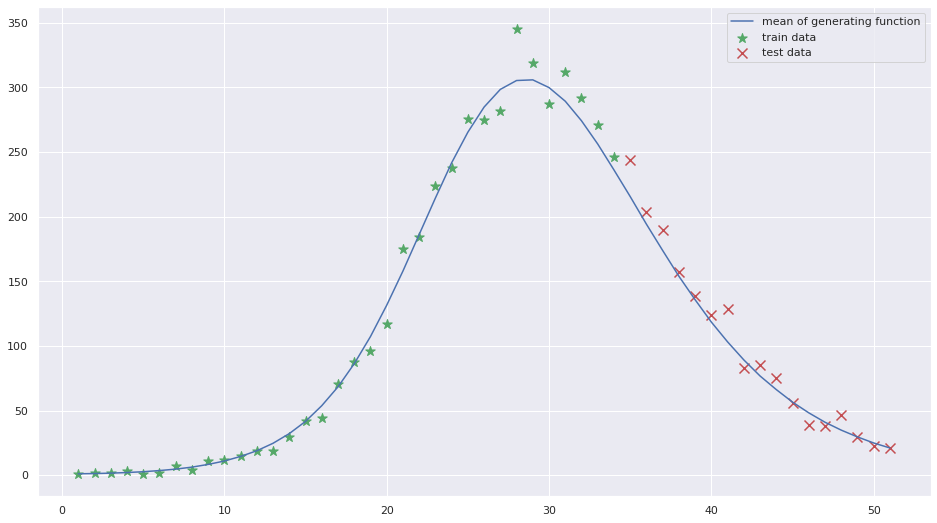

In [17]:
sampled_deaths = samples['deaths'][0].astype(int)
n_train = 2*weeks_analysed
plt.figure(figsize=(16,9))
plt.scatter(ts[:n_train], sampled_deaths[:n_train], c='g', marker='*', s=100, label="train data")
plt.scatter(ts[n_train:], sampled_deaths[n_train:], c='r', marker='x', s=100, label="test data")
plt.plot(ts, np.mean(samples['deaths'], axis=0), label="mean of generating function")
plt.legend()
plt.show()

Here the mean of deaths is shown in blue. The data used for training is shown in green. The red data is there for reference to evaluate the model performance.

#### Model fit

In [18]:
training_data = seapir_data.copy()
training_data["n_training"]   = n_train
training_data["n_test"]       = len(ts) - n_train
training_data["t_training"]   = ts[:n_train]
training_data["t_test"]       = ts[n_train:]
training_data["traffic"]      = np.empty((training_data['n_training'], 0))
training_data["traffic_pred"] = np.empty((training_data['n_test'], 0))
training_data["deaths"]       = sampled_deaths[:n_train]
training_data["deaths_pred"]  = sampled_deaths[n_train:]

sm = stan_utils.StanModel_cache("./seapir_model.stan")
fit = sm.sampling(training_data)
samples = fit.extract(permuted=True)

Using cached StanModel


Inference for Stan model: anon_model_a7da04991aa829155241427a8fd3fae8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
constant            1.0  1.9e-4 7.6e-3   0.98   0.99   0.99    1.0   1.01   1557    1.0
traffic_coeff[1]    1.0  1.9e-4 7.6e-3   0.98   0.99   0.99    1.0   1.01   1557    1.0
y[1,1]            5.0e6    1.01  39.81  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1557    1.0
y[2,1]            5.0e6    2.45  96.83  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1557    1.0
y[3,1]            5.0e6    4.67 184.47  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1557    1.0
y[4,1]            5.0e6    8.08 318.96  5.0e6  5.0e6  5.0e6  5.0e6  5.0e6   1557    1.0
y[5,1]            4.9e6   13.22 521.89  4.9e6  4.9e6  4.9e6  4.9e6  4.9e6   1558    1.0
y[6,1]            4.9e6   20.84 822.67  4.9e6  4.9e6  4.9e6  4.9e6  4.9e6   1558    1.0
y[7,1]            4

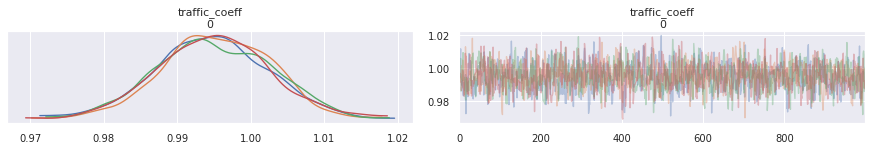

In [19]:
print(fit)
inf_data = az.convert_to_inference_data(fit)
az.plot_trace(inf_data, var_names=("traffic_coeff"))
plt.show()

#### Convergence diagnostics

All R-hat values are 1. Chains seem to have converged. Visually densities for beta seem to follow the same distribution.

#### Posterior predictive check -visualisations

We plot the model median and 90% confidence interval.

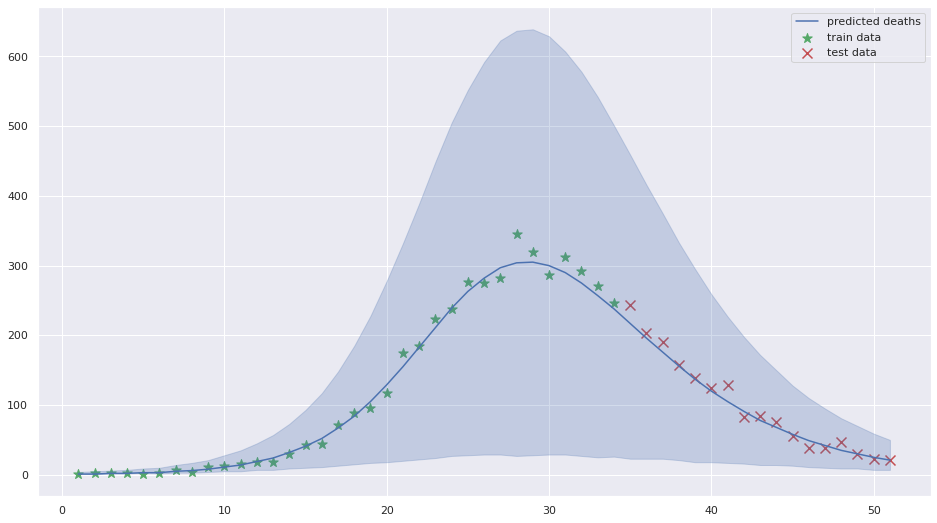

In [20]:
plt.figure(figsize=(16,9))
plt.scatter(ts[:n_train], sampled_deaths[:n_train], c='g', marker='*', s=100, label="train data")
plt.scatter(ts[n_train:], sampled_deaths[n_train:], c='r', marker='x', s=100, label="test data")
shadedplot(ts, samples['deaths_hat'], label="predicted deaths")
plt.legend()
plt.show()

The median seems to be a good fit to the data. However, it seems that all the data is contained in 90% confidence interval meanwhile we would expect out of 15 projected datapoints at least one to be outside of the confidence interval. This suggests that we could maybe getaway with modeling the outcomes with less diffuse distribution than Poisson distribution.

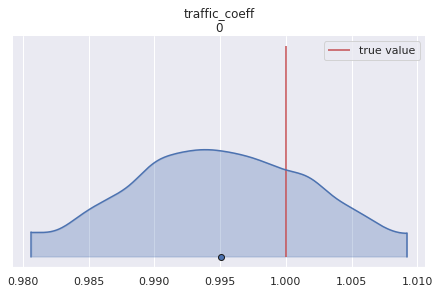

In [21]:
az.plot_density(inf_data, var_names=("traffic_coeff"), shade=0.3)
plt.vlines(generating_data["traffic_coeff"], 0, 100, colors='r', label='true value')
plt.legend()
plt.show()

It also seems that the model value for $\beta$ is guite close to the real value, and hence it seems that the model was able to learn the outcome quite well.

### $\beta$ is a linear function of traffic data

We generate a traffic component as a function of time $\tau(t)$.

51


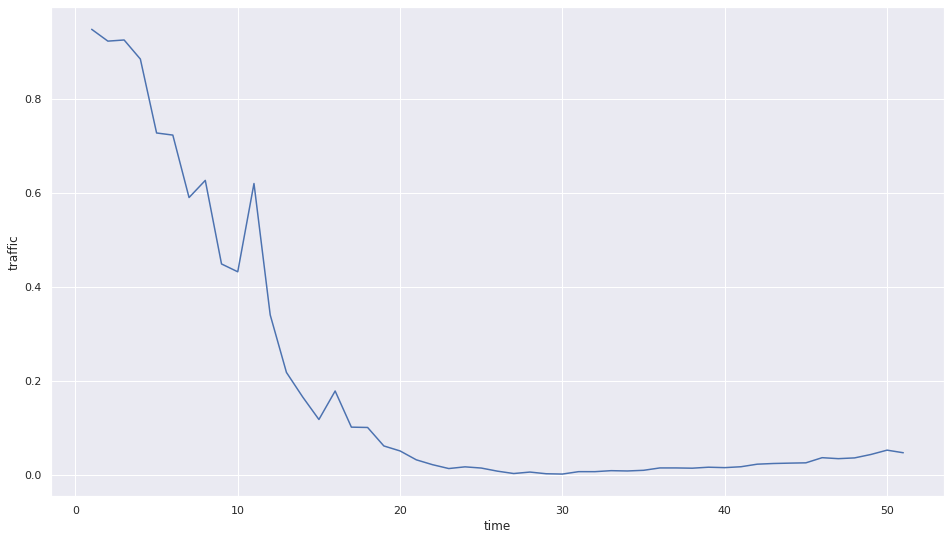

In [22]:
def traffic_component_gen(t, shape, loc, floor, inversed=False):
    '''
    Generate traffic_components
    '''
    exp_val = np.exp((np.array(t) - loc + np.random.normal(size=len(t)))* shape)
    sigmoid = exp_val / (exp_val + 1)
    if inversed:
        sigmoid = sigmoid * floor + floor
        return -1 * sigmoid + 1 + floor
    sigmoid = sigmoid * floor + (1 - floor)
    return sigmoid

traffic = np.concatenate([traffic_component_gen(ts[:30], 0.3, 10, 1, True), traffic_component_gen(ts[30:], 0.1, 80, 1, False)])
ts = ts
traffic = traffic
print(len(ts))
plt.figure(figsize=(16,9))
plt.plot(ts, traffic)
plt.xlabel("time")
plt.ylabel("traffic")
plt.show()

We use similar process to generate data as for constant $\beta$ model

Using cached StanModel


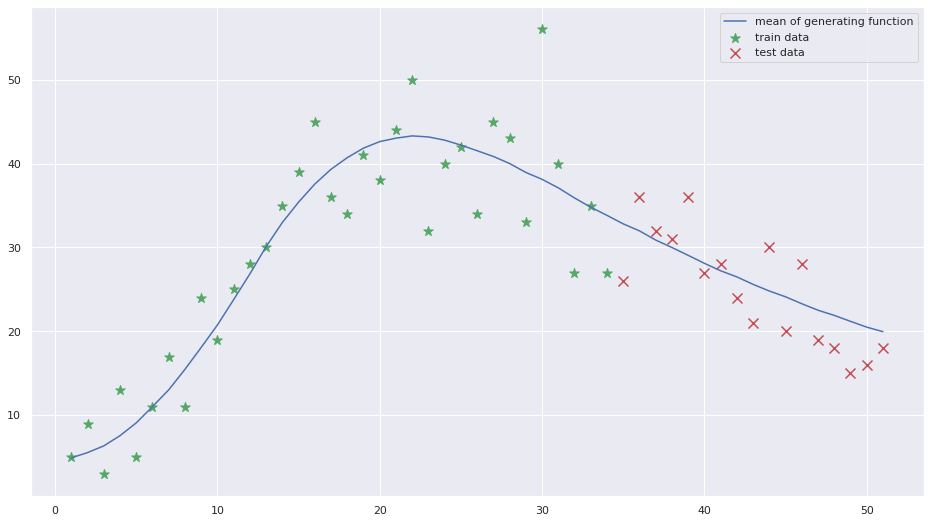

In [23]:
generating_data = seapir_data.copy()
generating_data['y0'] = initial_guess(N, 100, 20)
generating_data['traffic'] = traffic.reshape(-1, 1)
generating_data['traffic_coeff'] = np.array([0.2, 0.6])
generating_data["n_tcomponents"] = 1
sm_generator = stan_utils.StanModel_cache("./seapir_simulator.stan")
gen_fit = sm_generator.sampling(generating_data, algorithm="Fixed_param", seed=seed)
samples = gen_fit.extract(permuted=True)
sampled_deaths = samples['deaths'][0].astype(int)
plt.figure(figsize=(16,9))
plt.scatter(ts[:n_train], sampled_deaths[:n_train], c='g', marker='*', s=100, label="train data")
plt.scatter(ts[n_train:], sampled_deaths[n_train:], c='r', marker='x', s=100, label="test data")
plt.plot(ts, np.mean(samples['deaths'], axis=0), label="mean of generating function")
plt.legend()
plt.show()

In [24]:
training_data['y0'] = initial_guess(N, 100, 20)
training_data["traffic"]      = traffic[:n_train].reshape(-1,1)
training_data["traffic_pred"] = traffic[n_train:].reshape(-1,1)
training_data["n_tcomponents"]= 1
fit = sm.sampling(training_data)
samples = fit.extract(permuted=True)

Inference for Stan model: anon_model_a7da04991aa829155241427a8fd3fae8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
constant           1.17  1.4e-3   0.04    1.1   1.15   1.17    1.2   1.25    690   1.01
traffic_slope[1]  -0.85  2.5e-3   0.07  -0.98   -0.9  -0.85  -0.81  -0.72    702   1.01
traffic_coeff[1]   1.17  1.4e-3   0.04    1.1   1.15   1.17    1.2   1.25    690   1.01
traffic_coeff[2]  -0.85  2.5e-3   0.07  -0.98   -0.9  -0.85  -0.81  -0.72    702   1.01
y[1,1]            4.9e6   20.12 560.81  4.9e6  4.9e6  4.9e6  4.9e6  4.9e6    777   1.01
y[2,1]            4.9e6   42.39 1184.0  4.9e6  4.9e6  4.9e6  4.9e6  4.9e6    780   1.01
y[3,1]            4.9e6   69.31 1937.0  4.9e6  4.9e6  4.9e6  4.9e6  4.9e6    781   1.01
y[4,1]            4.9e6   99.93 2798.4  4.9e6  4.9e6  4.9e6  4.9e6  4.9e6    784   1.01
y[5,1]            4

array([[<AxesSubplot:title={'center':'traffic_coeff\n0'}>,
        <AxesSubplot:title={'center':'traffic_coeff\n0'}>],
       [<AxesSubplot:title={'center':'traffic_coeff\n1'}>,
        <AxesSubplot:title={'center':'traffic_coeff\n1'}>]], dtype=object)

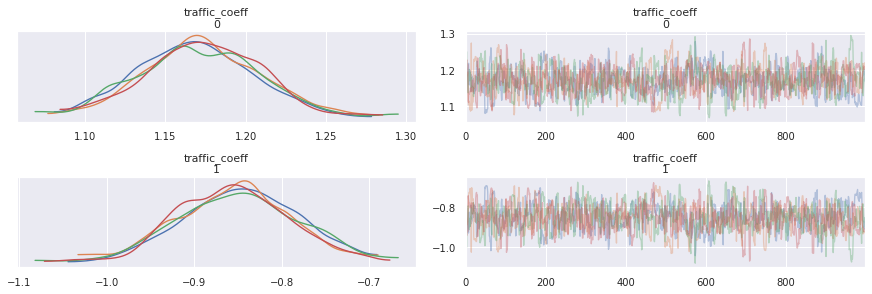

In [25]:
print(fit)
inf_data = az.convert_to_inference_data(fit)
az.plot_trace(inf_data, var_names=("traffic_coeff"))

Again chain seem to converge

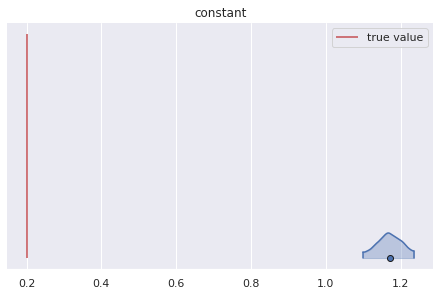

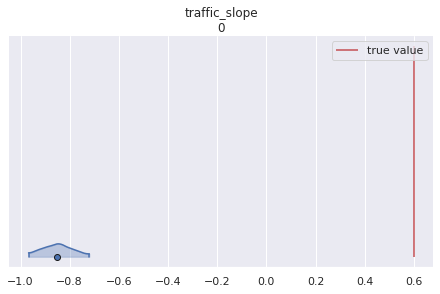

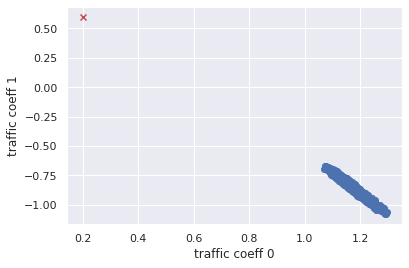

In [26]:
az.plot_density(inf_data, var_names=("constant"), shade=0.3)
plt.vlines(generating_data["traffic_coeff"][0], 0, 100, colors='r', label='true value')
plt.legend()
plt.show()
az.plot_density(inf_data, var_names=("traffic_slope"), shade=0.3)
plt.vlines(generating_data["traffic_coeff"][1], 0, 100, colors='r', label='true value')
plt.legend()
plt.show()
plt.scatter(samples["traffic_coeff"][:,0], samples["traffic_coeff"][:,1])
plt.scatter(generating_data['traffic_coeff'][0], generating_data['traffic_coeff'][1], marker='x', c='r')
plt.xlabel('traffic coeff 0')
plt.ylabel('traffic coeff 1')
plt.show()

Posterior samples seem to be quite far from actual datapoints. From posterior samples we notice that the model suffers from great degree of multicollinearity. It seems that only one wave of cases can only tell us about the value of $\beta$, but not about the actual function of $\beta=c_0 + c_1 \tau$. However, with enought prior information we can still try to fit a model to the data.

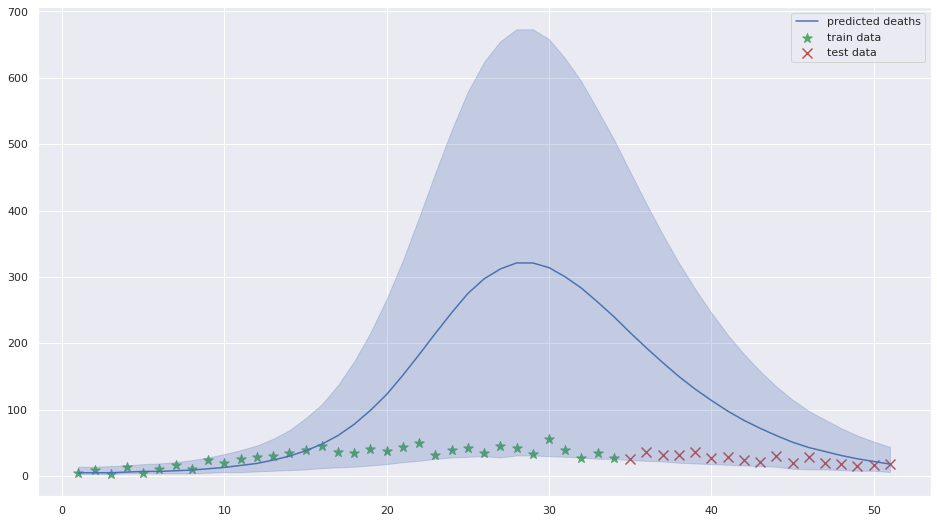

In [27]:
plt.figure(figsize=(16,9))
plt.scatter(ts[:n_train], sampled_deaths[:n_train], c='g', marker='*', s=100, label="train data")
plt.scatter(ts[n_train:], sampled_deaths[n_train:], c='r', marker='x', s=100, label="test data")
shadedplot(ts, samples['deaths_hat'], label="predicted deaths")
plt.legend()
plt.show()

Biased posterior samples cause a problem for posterior predictive distribution too and hence it isn't too reliable.

## Real data experiment, Spain

### The used data

In [17]:
current_country = 'Spain'

current_seir_data = initialize_seir(current_country)

current_retail = get_traffic_smooths_shifted(current_country, "traffic_retail_smooth" )
current_grocery = get_traffic_smooths_shifted(current_country, "traffic_supermarket_smooth" )
current_parks = get_traffic_smooths_shifted(current_country, "traffic_parks_smooth" )
current_transit_stations = get_traffic_smooths_shifted(current_country, "traffic_transit_stations_smooth" )
current_workplaces = get_traffic_smooths_shifted(current_country, "traffic_workplaces_smooth" )
current_residential = get_traffic_smooths_shifted(current_country, "traffic_residential_smooth" )

print_countries_values(current_seir_data['deaths'], current_retail, current_grocery, current_parks,
                       current_transit_stations, current_workplaces, current_residential)

Smoothened deaths
[1, 8, 20, 31, 24, 58, 47, 106, 105, 122, 120, 120, 139, 160, 422, 276, 264]

Smoothened and shifted retail traffic
[-0.18, -0.15, -0.17, -0.19, -0.21, -0.18, -0.18, -0.21, -0.24, -0.25, -0.25, -0.28, -0.33, -0.33, -0.38, -0.4, -0.4]

Smoothened and shifted grocery traffic
[-0.05, -0.03, -0.07, -0.04, -0.06, -0.04, -0.05, -0.06, -0.05, -0.02, -0.02, -0.05, -0.03, -0.0, -0.05, -0.04, -0.05]

Smoothened and shifted park traffic
[0.5, 0.66, 0.67, 0.66, 0.5, 0.36, 0.32, 0.18, 0.06, -0.03, 0.03, 0.06, -0.09, -0.1, -0.17, -0.11, -0.1]

Smoothened and shifted transit station traffic
[-0.32, -0.33, -0.36, -0.37, -0.37, -0.32, -0.3, -0.28, -0.28, -0.24, -0.22, -0.26, -0.24, -0.27, -0.33, -0.31, -0.29]

Smoothened and shifted workplace traffic
[-0.23, -0.27, -0.32, -0.31, -0.29, -0.24, -0.26, -0.21, -0.21, -0.18, -0.18, -0.24, -0.17, -0.18, -0.24, -0.22, -0.21]

Smoothened and shifted residential traffic
[0.03, 0.03, 0.04, 0.04, 0.05, 0.04, 0.04, 0.04, 0.05, 0.05, 0.05, 0.07, 0

### Naive model 1: $\beta$ is a constant 

#### Prior choice 1

$c_1 \sim \text{Normal}(0,1)$ s.t. $c_1 \geq 0$,

Using cached StanModel


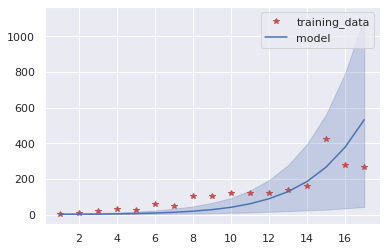

In [18]:
sm = stan_utils.StanModel_cache("./seapir_model.stan")
current_seir_data_constant = current_seir_data.copy()
current_seir_data_constant['traffic'] = np.empty((weeks_analysed, 0))
fit_constant_pc1 = test_model(current_seir_data_constant, sm, 1)

Biggest r-hat-value:
1.0034144382801473


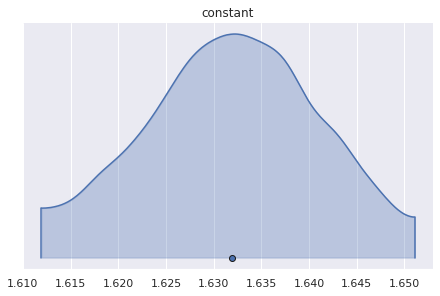

In [38]:
irhat = fit_constant_pc1.summary()['summary_colnames']
irhat = irhat.index("Rhat")
irhat = fit_constant_pc1.summary()["summary"][:, irhat]
print("Biggest r-hat-value:")
print(np.nanmax(irhat))

inf_data = az.convert_to_inference_data(fit_constant_pc1)
az.plot_density(inf_data, var_names=("constant"), shade=0.3)
plt.show()

#### Prior choice 2

$c_1 \sim \text{Normal}(5,2)$ s.t. $c_1 \geq 0$,

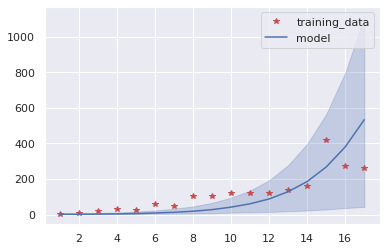

In [24]:
fit_constant_pc2 = test_model(current_seir_data_constant, sm, 2)

Biggest r-hat-value:
1.001894499330292


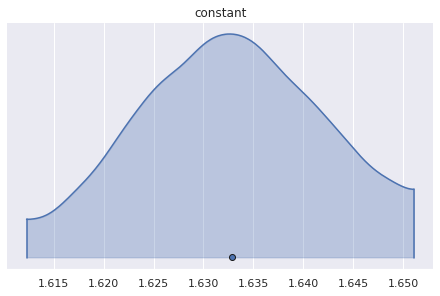

In [39]:
irhat = fit_constant_pc2.summary()['summary_colnames']
irhat = irhat.index("Rhat")
irhat = fit_constant_pc2.summary()["summary"][:, irhat]
print("Biggest r-hat-value:")
print(np.nanmax(irhat))

inf_data = az.convert_to_inference_data(fit_constant_pc2)
az.plot_density(inf_data, var_names=("constant"), shade=0.3)
plt.show()

### Model 2, retail residential: $\beta(t) = c_1 + c_2 \bar{\tau}_{t',c}^1$  where $t' = \text{min}(T)$ s.t. $t<t'$

#### Prior choice 1

$c_1, c_2 \sim \text{Normal}(0,1)$ s.t. $c_1,c_2 \geq 0$

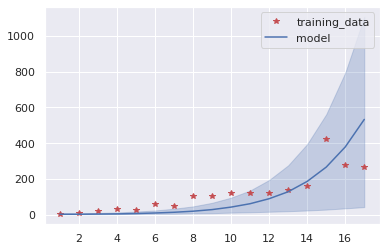

In [29]:
current_seir_data_residential = current_seir_data.copy()
current_seir_data_residential['traffic'] = np.array(current_residential).reshape(-1,1)
fit_residential_pc1 = test_model(current_seir_data_residential, sm, 1)

Biggest r-hat-value:
1.0031537439527416


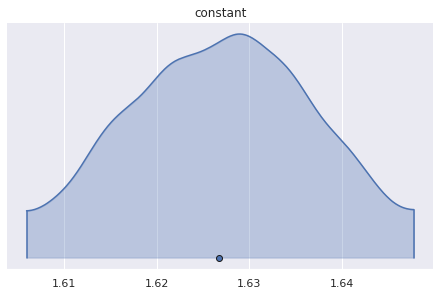

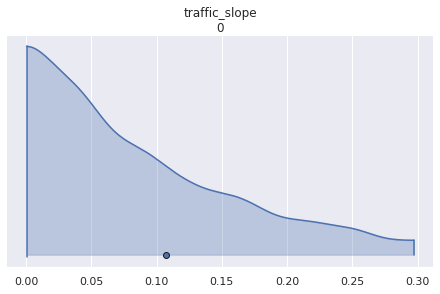

In [40]:
irhat = fit_residential_pc1.summary()['summary_colnames']
irhat = irhat.index("Rhat")
irhat = fit_residential_pc1.summary()["summary"][:, irhat]
print("Biggest r-hat-value:")
print(np.nanmax(irhat))

inf_data = az.convert_to_inference_data(fit_residential_pc1)
az.plot_density(inf_data, var_names=("constant"), shade=0.3)
plt.show()
az.plot_density(inf_data, var_names=("traffic_slope"), shade=0.3)
plt.show()

#### Prior choice 2

$c_1, c_2 \sim \text{Normal}(5,2)$ s.t. $c_1 \geq 0$

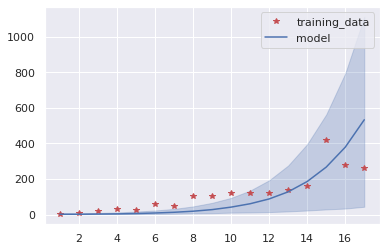

In [35]:
fit_retail_pc2 = test_model(current_seir_data_residential, sm, 2)

Biggest r-hat-value:
1.0031537439527416


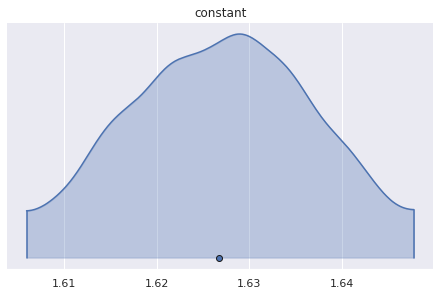

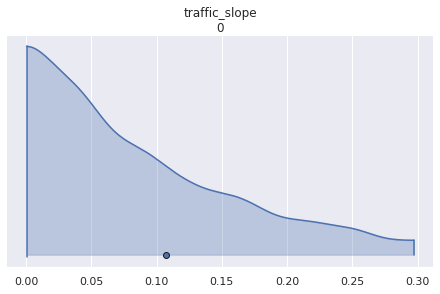

In [41]:
irhat = fit_residential_pc1.summary()['summary_colnames']
irhat = irhat.index("Rhat")
irhat = fit_residential_pc1.summary()["summary"][:, irhat]
print("Biggest r-hat-value:")
print(np.nanmax(irhat))

inf_data = az.convert_to_inference_data(fit_residential_pc1)
az.plot_density(inf_data, var_names=("constant"), shade=0.3)
plt.show()
az.plot_density(inf_data, var_names=("traffic_slope"), shade=0.3)
plt.show()

### Sensitivity analysis with respect to prior choices

Reasonably small changes in priors don't seem to affect the on posterior predictive distribution.

### Predictive performance assessment (part 10)

- Let's use Leave future out, LFO-method, with $M=12, L=3$. 

- "If we have many competing models we may also need to first decide which of the models (or which combination of the models) we should rely on for predictions. In these situations the best we can do is to use methods for approximating the expected predictive performance of our models using only the observations of the time series we already have." https://mc-stan.org/loo/articles/loo2-lfo.html

In [ ]:
lfo_samples = []
lfo_samples.append(lfo_elpd(sm, L, M, current_seir_data_constant))

In [57]:
# All the traffic components that gave reasonable values
seir_data_all = [current_seir_data_constant, current_seir_data_retail]

for seir_data_current in seir_data_all:
    lfo_samples.append(lfo_elpd(sm, L, M, seir_data_current))

Biggest r-hat-value of the current loop:
1.0048601445940473


Biggest r-hat-value of the current loop:
1.0081410086823361


Biggest r-hat-value of the current loop:
1.016674524545789


Biggest r-hat-value of the current loop:
1.0015857584378358


Biggest r-hat-value of the current loop:
1.001871336452397


Biggest r-hat-value of the current loop:
1.0007333444613429


Biggest r-hat-value of the current loop:
1.0014866694109061


Biggest r-hat-value of the current loop:
1.0023592601298323


Biggest r-hat-value of the current loop:
1.00276927146255


In [58]:
print(lfo_samples)

[array([-311.73024458, -256.65830806, -312.72915331]), array([nan, nan, nan]), array([-262.07776912, -227.15011202, -267.97366596]), array([-269.41446258, -205.03068484, -171.12984441])]


In [65]:
description = ['constant', 'residential', 'retail', 'grocery']

print('LFO-values')
print()

for i in range(len(lfo_samples)):
    print(description[i] + ':')
    print(sum(lfo_samples[i]))
    print()

LFO-values

constant:
-881.1177059591237

retail:
nan

grocery:
-757.2015470924873

residential:
-645.5749918305235



Based on the LFO values surprisingly residential traffic components seem to provide best estimates.

### Discussion of the results and potential improvements.

For SEAPIR-model it seems that we can quite easily learn the value for $\beta$ and fit to one wave of cases.
However, it seems that it is hard to infer linear dependence from just a one wave of covid cases. We could try to use data from longer time period with two waves of corona cases. That might provide enough data to get over the problem of multicollinearity.

### Conclusion what was learned from the data analysis

It seems that it is quite easy to learn transmission rate parameter.

### Self-reflection of what the group learned while making the project

We learned the importance of making good model tests to ensure that the model which we are building is still working. We also learned the importance of reparameterizing stan models. In our case bad parameterization increased the computational time 

### References

- https://www.medrxiv.org/content/10.1101/2020.03.03.20030593v1.supplementary-material
    - This has a great supplementary material section, and our model is based on that

- https://www.fhi.no/en/id/infectious-diseases/coronavirus/coronavirus-modelling-at-the-niph-fhi/
    - The Norwegian Institute of Public Health has a great report of modeling COVID-19 with extended SEIR-model 

- https://www.medrxiv.org/content/10.1101/2020.05.28.20116129v3.full.pdf
    - More like nice to read to get some ideas, not direct connection to our model

- https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html
    - A lot of practical ideas for SIR-model implementation with STAN 

- https://mc-stan.org/loo/articles/loo2-lfo.html
    - Leave future out